In [3]:
import pandas as pd
import numpy as np

# Manipulation de données

# j'ai récupéré un dataset de 23000 données sur github https://github.com/kirill-menke/house-pricing-prediction/blob/main/data/apartments_train.csv, le format ne correspond pas à ce que je veux, je vais donc le modifier pour qu'il corresponde aux attentes.
# voilà les colonnes du fichier id,seller,price,area_total,area_kitchen,area_living,floor,rooms,layout,ceiling,bathrooms_shared,bathrooms_private,windows_court,windows_street,balconies,loggias,condition,phones,building_id
# et voilà ce que je veux : id,annee,balcon,garage,note,price_category

db = pd.read_csv('data/github_appartements.csv')

# 1. Supprimer les colonnes inutiles
db = db.drop(columns=['seller', 'area_kitchen', 'area_living', 'floor', 'layout', 'ceiling', 'bathrooms_shared', 'bathrooms_private', 'windows_court', 'windows_street', 'loggias', 'condition', 'phones', 'building_id'])
# 2. Renommer les colonnes pour qu'elles correspondent à ce que je veux
db = db.rename(columns={'area_total': 'surface', 'balconies': 'balcon', 'rooms': 'nbRooms'})
# 3. Ajouter une colonne annee qui correspond à l'année de construction de l'appartement
db['annee'] = np.random.randint(2005, 2024, db.shape[0]) # j'accepte que l'année soit aléatoire et non cohérente ;)
db['garage'] = np.random.choice([True, False], db.shape[0])
db['price_category'] = np.random.choice(['low', 'medium', 'high', 'scam'], db.shape[0], p=[0.3, 0.6, 0.09, 0.01])
db['note'] = np.random.randint(1, 5, db.shape[0])

db['annee'] = 2024 - (9 * db['price'] / db['price'].max()).astype(int)
db['annee'] = db['annee'].clip(2024, 2005)
price_percentile = db['price'].rank(pct=True)
db['garage'] = np.random.rand(len(db)) < price_percentile

# Function to categorize price
def categorize_price(row):
    price_per_sqm = row['price'] / row['surface']
    if price_per_sqm < 150000:
        return 'low'
    elif price_per_sqm < 200000:
        return 'normal'
    elif price_per_sqm < 500000:
        return 'high'
    else:
        return 'scam'

# Add 'price_category' column
db['price_category'] = db.apply(categorize_price, axis=1)

# Add 'note' column (influenced by price_category and features)
def assign_note(row):
    base_note = {'low': 2, 'normal': 3, 'high': 4, 'scam': 1}[row['price_category']]

    # Adjust based on features
    if row['garage']:
        base_note += 0.5
    if row['nbRooms'] > 2:
        base_note += 0.5
    if row['surface'] > db['surface'].median():
        base_note += 0.5

    return min(round(base_note), 5)  # Cap at 5

db['note'] = db.apply(assign_note, axis=1)

db.to_csv('data/appartements.csv', index=False)

db.head()

,id,price,surface,nbRooms,balcon,annee,garage,price_category,note
0,0,7139520.0,59.2,2.0,NaN,2024,True,low,2
1,1,10500000.0,88.0,3.0,1.0,2024,True,low,4
2,2,9019650.0,78.5,3.0,NaN,2024,True,low,4
3,3,10500000.0,88.0,3.0,0.0,2024,False,low,3
4,4,13900000.0,78.0,2.0,0.0,2024,False,normal,4


In [4]:
# 3. Avec Numpy et Pandas:
# - Sur la surface: Moyenne, écart-type, surface minimale et maximale.
db = pd.read_csv('data/appartements.csv')

# Moyenne, écart-type, surface minimale et maximale
surface_mean = db['surface'].mean()
surface_std = db['surface'].std()
surface_min = db['surface'].min()
surface_max = db['surface'].max()

print(f"Surface: moyenne={surface_mean}, ecart-type={surface_std}, min={surface_min}, max={surface_max}")

Surface: moyenne=74.45099935580846, ecart-type=58.67137288575908, min=9.3, max=2181.0


In [5]:
# - Sur l'annee: Moyenne, construction la plus ancienne, la plus récente.

annee_mean = db['annee'].mean()
oldest_year_rows = db[db['annee'] == db['annee'].min()]
latest_year_rows = db[db['annee'] == db['annee'].max()]

print(annee_mean)
print(oldest_year_rows.head())
print(latest_year_rows.head())

2023.993300407988
          id         price  surface  nbRooms  balcon  annee  garage  \
3217    3217  2.600000e+09   2181.0      6.0     NaN   2015    True   
21414  21414  2.600000e+09   2181.0      1.0     NaN   2015    True   

      price_category  note  
3217            scam     2  
21414           scam     2  
   id       price  surface  nbRooms  balcon  annee  garage price_category  \
0   0   7139520.0     59.2      2.0     NaN   2024    True            low   
1   1  10500000.0     88.0      3.0     1.0   2024    True            low   
2   2   9019650.0     78.5      3.0     NaN   2024    True            low   
3   3  10500000.0     88.0      3.0     0.0   2024   False            low   
4   4  13900000.0     78.0      2.0     0.0   2024   False         normal   

   note  
0     2  
1     4  
2     4  
3     3  
4     4  


In [6]:
# - Sur le balcon: Proportion d'appartements avec un balcon.

balcon_proportion = db['balcon'].mean()
print("proportion de bien avec un balcon", balcon_proportion * 100, "%")

proportion de bien avec un balcon 55.636506071288686 %


In [7]:
# - Comptage du nombre d'appartements dans chaque catégorie de prix.

db['price_category'].value_counts()


price_category
high      9755
normal    7740
low       4261
scam      1529
Name: count, dtype: int64

In [8]:
# Nombre de chambre par appartement (nbRooms) : Moyenne, médianne, variance, écart-type

nbRoomsMean = db['nbRooms'].mean()
nbRoomsMedian = db['nbRooms'].median()
nbRoomsVar = db['nbRooms'].var()
nbRoomsEcartType = db['nbRooms'].std()

print(f"Moyenne={nbRoomsMean}, Médiane={nbRoomsMedian}, Variance={nbRoomsVar}, Ecart-type={nbRoomsEcartType}")

Moyenne=2.189349366544986, Médiane=2.0, Variance=1.1580552586713442, Ecart-type=1.0761297592164916


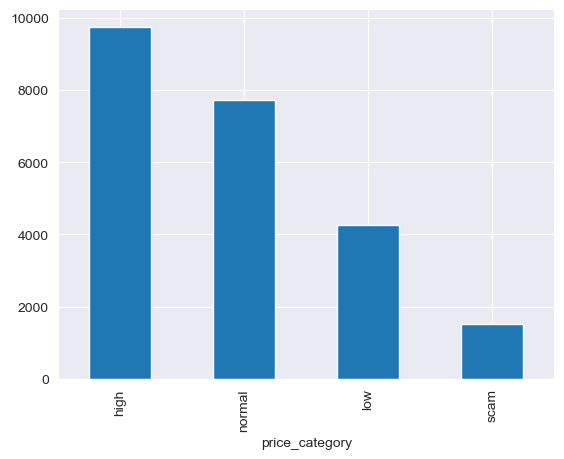

In [9]:
# Avec Matplop:
# Créer un Diagramme à barres pour afficher la répartition des catégories de prix (par exemple, combien d'appartements sont "low", "normal", "high", "scam").

import matplotlib.pyplot as plt

db['price_category'].value_counts().plot(kind='bar')
plt.show()


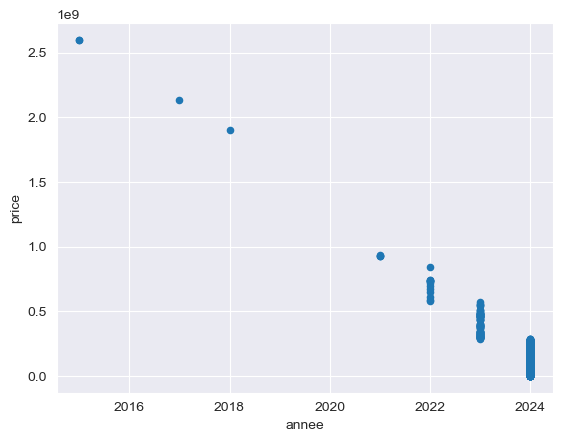

On peut voir que les prix des appartements descendent avec l'année de construction
c'est normal car c'est comme ça que j'ai généré les données ;)


In [10]:
# Bonus: heatmap pour voir la correlation entre Année de construction et prix afin de voir si les appartements plus récents ont tendance à être plus chers.

db.plot.scatter(x='annee', y='price')
plt.show()

print("On peut voir que les prix des appartements descendent avec l'année de construction")
print("c'est normal car c'est comme ça que j'ai généré les données ;)")

In [24]:
# 1. Compléter avec une nouvelle colonne ville dans votre dataset si l'appartement est de Lyon, Paris ou Marseille
db['city'] = np.random.choice(['Lyon', 'Paris', 'Marseille'],db.shape[0],p=[0.2,0.5,0.3])
db.to_csv('data/appartements.csv', index=False)

db.head()

,id,price,surface,nbRooms,balcon,annee,garage,price_category,note,city
0,0,7139520.0,59.2,2.0,NaN,2024,True,low,2,Marseille
1,1,10500000.0,88.0,3.0,1.0,2024,True,low,4,Paris
2,2,9019650.0,78.5,3.0,NaN,2024,True,low,4,Marseille
3,3,10500000.0,88.0,3.0,0.0,2024,False,low,3,Marseille
4,4,13900000.0,78.0,2.0,0.0,2024,False,normal,4,Marseille


In [22]:
# 2. Créer une prédiction par regression linéaire sur la note en fonction de la ville, de la surface et du prix
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

X = pd.get_dummies(db[['surface', 'price', 'city']])
y = db['note']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

from sklearn.metrics import r2_score, mean_squared_error

r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
print(f"R2={r2}, MSE={mse}")

R2=0.09140542701293186, MSE=0.930636936363423


In [13]:
# 3. Créer une prédiction par regression linéaire sur l'année en fonction de la ville puis donnéer sa propabilité (R2) et son taux d'erreur en année (RSME ou MSE)

X = pd.get_dummies(db[['city']])
y = db['annee']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

r2 = r2_score(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred)
print(f"R2={r2}, RMSE={rmse}")

R2=-0.00013123232364464776, RMSE=0.014985886485127348


In [14]:
# 4. Créer une classification logistique pour savoir si il y a un garage en fonction du prix et de la ville
from sklearn.linear_model import LogisticRegression

X = pd.get_dummies(db[['price', 'city']])
y = db['garage']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

model = LogisticRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

from sklearn.metrics import accuracy_score, recall_score, f1_score

logistic_accuracy = accuracy_score(y_test, y_pred)
logistic_recall = recall_score(y_test, y_pred)
logistic_f1 = f1_score(y_test, y_pred)

In [19]:
# 5. Créer une classification par KNN pour savoir si il a un balcon en fonction du prix et de la ville
from sklearn.neighbors import KNeighborsClassifier

dropped_db = db.dropna()

X = pd.get_dummies(dropped_db[['price', 'city']])
y = dropped_db['balcon']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

model = KNeighborsClassifier()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

knn_accuracy = accuracy_score(y_test, y_pred)
knn_recall = recall_score(y_test, y_pred,  average='macro')
knn_f1 = f1_score(y_test, y_pred,  average='macro')

In [21]:
# 6.  Pour les 2 classification précédente: afficher le accuracy, recall puis F1 Score
print(pd.DataFrame({
    'Logistic Regression': [logistic_accuracy, logistic_recall, logistic_f1],
    'KNN': [knn_accuracy, knn_recall, knn_f1]
}, index=['Accuracy', 'Recall', 'F1 Score']))

          Logistic Regression       KNN
Accuracy             0.721280  0.519389
Recall               0.565901  0.221071
F1 Score             0.672222  0.216377
